In [19]:
import pandas as pd
import matplotlib
import re
from tqdm import tqdm
import numpy as np
import scipy.sparse as sp
import json
import matplotlib.pyplot as plt

In [25]:
train = pd.read_csv("dataset/train.csv")
train.head(10)

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL
5,id22965,"A youth passed in solitude, my best years spen...",MWS
6,id09674,"The astronomer, perhaps, at this point, took r...",EAP
7,id13515,The surcingle hung in ribands from my body.,EAP
8,id19322,I knew that you could not say to yourself 'ste...,EAP
9,id00912,I confess that neither the structure of langua...,MWS


### Data Analysis

EAP    7900
MWS    6044
HPL    5635
Name: author, dtype: int64


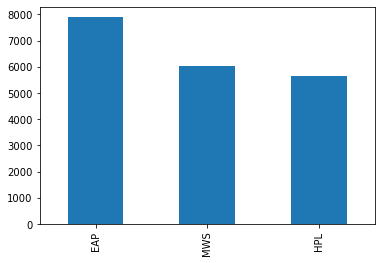

In [26]:
# Finding distribution of data between classes.
print(train["author"].value_counts())
author_freq=train["author"].value_counts()
author_freq.plot.bar()
plt.show()

In [ ]:
# Plotting 20 most frequent words in the text along with their frequencies
all_words_freq = train['text'].str.split(expand=True).unstack().value_counts()
all_words_freq[0:20].plot.bar()
plt.show()

### OBSERVATION
#### We observe from the above bar graph that the most frequent words don't carry much information and are just pronouns, 

In [3]:
train.describe()

,id,text,author
count,19579,19579,19579
unique,19579,19579,3
top,id26305,"This process, however, afforded me no means of...",EAP
freq,1,1,7900


In [4]:
# Finding unique words in the text. 
unique_words = set()

for i in range(train.shape[0]):
    text = train["text"][i]
    words = re.findall("[a-z0-9]+", text.lower())
    unique_words.update(words)

In [5]:
# Size of vocalubary consisting of distinct words present in the dataset
len(unique_words)

25078

In [6]:
# Removing Stopwords

relevant_words = unique_words
stopwords = ["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", "during", "before", "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", "now"]

for stopword in stopwords:
    try:
        relevant_words.remove(stopword)
    except KeyError:
        pass

In [7]:
# Size of vocalubary consisting of distinct words present in the dataset after removing stopwords
len(relevant_words)

24951

In [8]:
columns = sorted(list(relevant_words))
columns[:10]

['aaem',
 'ab',
 'aback',
 'abaft',
 'abandon',
 'abandoned',
 'abandoning',
 'abandonment',
 'abaout',
 'abased']

### Creating the Feature Matrix
#### Feature matrix 
It is An r×c matrix M where r is the number of examples and c is the size of the vocabulary consisting of distinct words present in the dataset. Each row corresponds to an example of the dataset and each column corresponds to
a word in the vocabulary. Mij = 1 if and only if the j-th word is present in the text of the i example. The feature matrix is stored in npz format at the end of this file to save computation time.

#### wordIndex
It is a dictionary containing the mapping of words to their corresponding column index in the feature matrix. It is finally stored in json format.


In [9]:
wordIndex = {}
for idx,word in enumerate(columns):
    wordIndex[word] = idx

In [10]:
with open("word_index.json","w") as file:
    file.write(json.dumps(wordIndex,indent = 4))

In [11]:
# lil_matrix is better in changing sparse structure than csr_matrix.
dimX = train.shape[0]
dimY = len(columns)
featureMatrix = sp.lil_matrix((dimX,dimY),dtype=int)
featureMatrix.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [12]:
#  Mapping for each column : j => [i1,i2,i3...] i.e given a fixed j ,for all i such that featureMatrix[i,j] = 1 
trueRows = {}

for word in columns:
    trueRows[wordIndex[word]] = []

for i in range(train.shape[0]):
    text = train["text"][i]
    words = set(re.findall("[a-z0-9]+", text.lower()))
    for word in words:
        if word in stopwords:
            continue
        trueRows[wordIndex[word]].append(i)

In [13]:
for col,rowlist in tqdm(trueRows.items()):
    featureMatrix[rowlist,col] = 1

100%|██████████| 24951/24951 [00:01<00:00, 14303.36it/s]


In [14]:
# Once lil_matrix has served its purpose , convert it to csr_matrix for faster arithmetic, vectorization
# and being able to save it

featureMatrix = featureMatrix.tocsr()

In [15]:
featureMatrix.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [19]:
featureMatrix.shape

(19579, 24951)

In [20]:
sp.save_npz(file = "feature_matrix.npz", matrix = featureMatrix)